## Predictor pLDDT, ipTM para Alphafold

### 0 . Obtención de datos

In [3]:
from data.scripts.preprocessing import process
import os

process(os.path.join(os.getcwd(),'data','traning_alphafold_predictor'))

Buscando archivos en: c:\Users\balde\Desktop\MAESTRIA MNA\PI\drug-design-diabetes-team29\data\traning_alphafold_predictor

Se encontraron 9 archivos. Procesando...
  [OK] Procesado: mpnn_results(1).csv con 560 registros
  [OK] Procesado: mpnn_results(2).csv con 560 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros
  [OK] Procesado: mpnn_results.csv con 120 registros

Total de registros: 1960

¡ÉXITO! Se ha creado el archivo consolidado en:
c:\Users\balde\Desktop\MAESTRIA MNA\PI\drug-design-diabetes-team29\data\traning_alphafold_predictor\./train.csv
Total de filas consolidadas: 1960


### 1. Configuración del Tokenizador y Modelo 

In [4]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from transformers import AutoTokenizer, AutoModel

In [5]:
#Cargamos modelo y tokenizador
MODEL_NAME = "facebook/esm2_t33_650M_UR50D"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [7]:
model = AutoModel.from_pretrained(MODEL_NAME) #Descarga el modelo por primera vez
model.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 1280, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-32): 33 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=1280, out_features=1280, bias=True)
            (key): Linear(in_features=1280, out_features=1280, bias=True)
            (value): Linear(in_features=1280, out_features=1280, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=1280, out_features=5120, bias=True)
        )
        (output): EsmOut

### 2. Análisis de datos

In [8]:
df = pd.read_csv("data/traning_alphafold_predictor/train.csv")
df.head()

,plddt,i_ptm,seq
0,0.262914,0.156545,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
1,0.392581,0.493991,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
2,0.288697,0.326205,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
3,0.453222,0.579009,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...
4,0.279486,0.337905,VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDG...


In [9]:
df.shape

(1960, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   plddt   1960 non-null   float64
 1   i_ptm   1960 non-null   float64
 2   seq     1960 non-null   object 
dtypes: float64(2), object(1)
memory usage: 46.1+ KB


In [11]:
df.describe()

,plddt,i_ptm
count,1960.000000,1960.000000
mean,0.412583,0.207358
std,0.108691,0.137802
min,0.213786,0.013096
25%,0.302906,0.080790
50%,0.426787,0.175945
75%,0.508388,0.322895
max,0.680502,0.666694


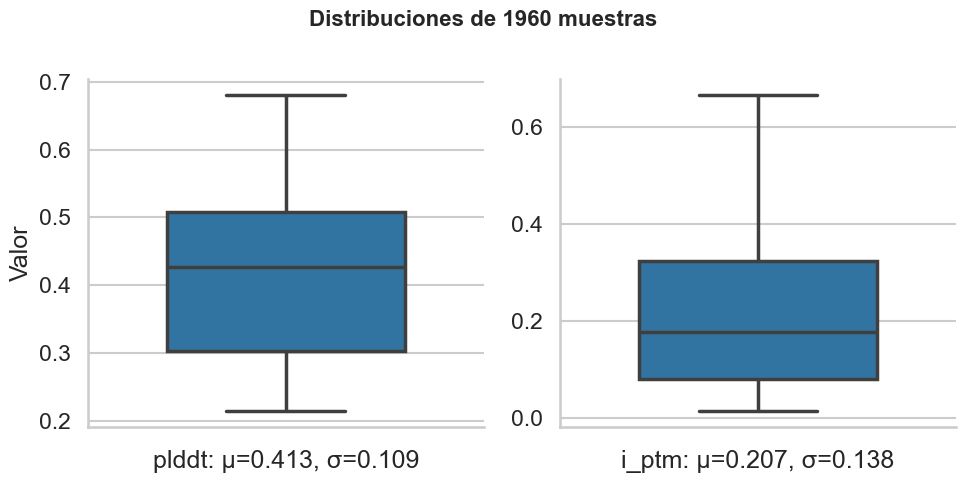

In [12]:
%matplotlib inline
# Calcula estadísticas
stats_text_plddt = f'plddt: μ={df["plddt"].mean():.3f}, σ={df["plddt"].std():.3f}'
stats_text_iptm  = f'i_ptm: μ={df["i_ptm"].mean():.3f}, σ={df["i_ptm"].std():.3f}'
num_muestras = df.shape[0]
#Estilos de gráfica
sns.set_style("whitegrid")
sns.set_context("talk")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'Distribuciones de {num_muestras} muestras', fontsize=16, fontweight='bold')
sns.boxplot(data=df,y="plddt",ax = axes[0],linewidth=2.5,width=0.6)
axes[0].set_xlabel(stats_text_plddt)
axes[0].set_ylabel('Valor')
sns.boxplot(data=df,y="i_ptm",ax = axes[1],linewidth=2.5,width=0.6)
axes[1].set_xlabel(stats_text_iptm)
axes[1].set_ylabel('')
sns.despine()
plt.tight_layout()


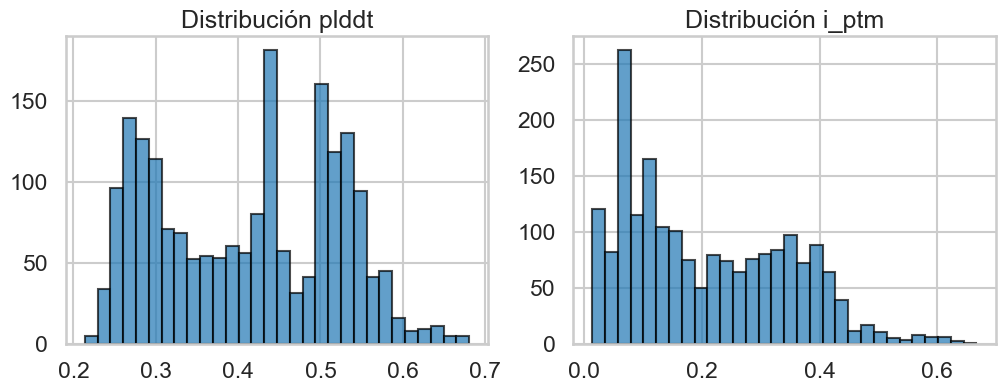

In [13]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['plddt'], bins=30, alpha=0.7,edgecolor='black')
axes[0].set_title('Distribución plddt')
axes[1].hist(df['i_ptm'], bins=30,alpha=0.7,edgecolor='black')
axes[1].set_title('Distribución i_ptm')
plt.show()

In [14]:
# Crear tabla con estadísticas
stats_data = {
    'Variable': ['plddt', 'i_ptm'],
    'Media (μ)': [df['plddt'].mean(), df['i_ptm'].mean()],
    'Desv. Est (σ)': [df['plddt'].std(), df['i_ptm'].std()],
    'Asimetría': [stats.skew(df['plddt']), stats.skew(df['i_ptm'])],
    'Curtosis': [stats.kurtosis(df['plddt']), stats.kurtosis(df['i_ptm'])]
}

stats_df = pd.DataFrame(stats_data)

# Redondear valores
stats_df = stats_df.round(3)

print(stats_df)


  Variable  Media (μ)  Desv. Est (σ)  Asimetría  Curtosis
0    plddt      0.413          0.109      0.015    -1.218
1    i_ptm      0.207          0.138      0.527    -0.669


### 3. Feature Engineering

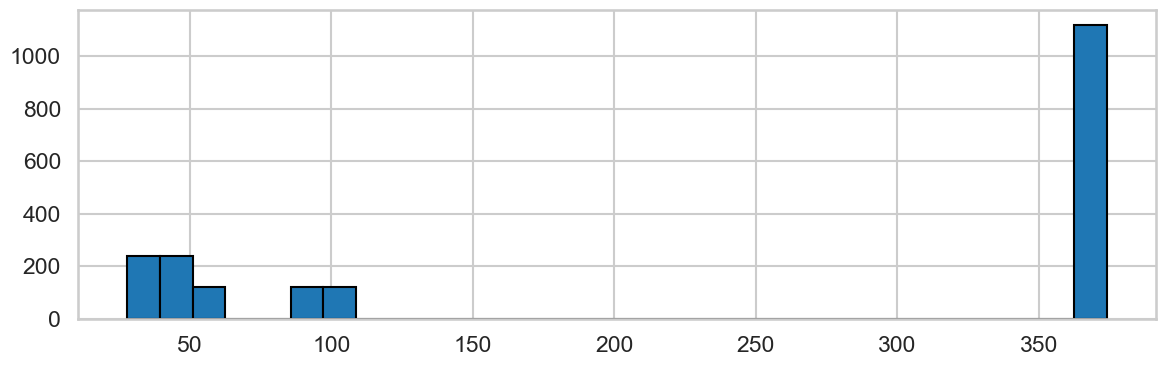

In [15]:
%matplotlib inline
df['seq_length'] = df['seq'].apply(len)
plt.figure(figsize=(12, 4))
# Histograma de longitudes
plt.hist(df['seq_length'], bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Longitud vs plddt')

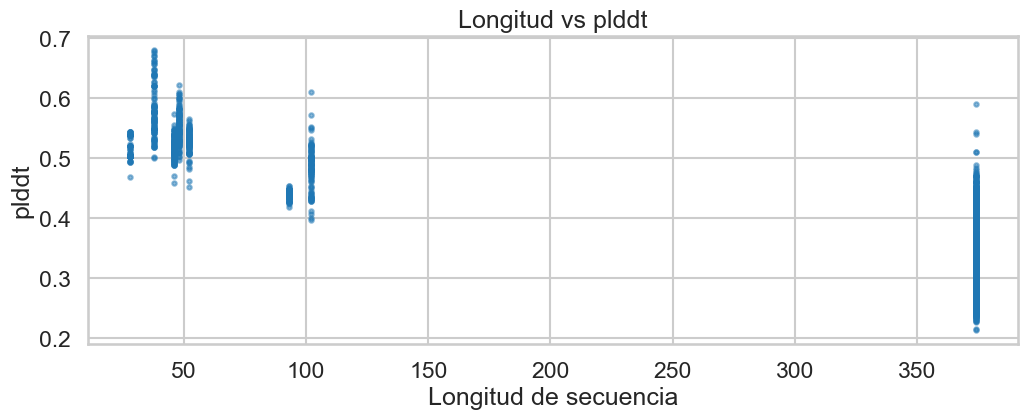

In [16]:
plt.figure(figsize=(12, 4))
plt.scatter(df['seq_length'], df['plddt'], alpha=0.5, s=10)
plt.xlabel('Longitud de secuencia')
plt.ylabel('plddt')
plt.title('Longitud vs plddt')

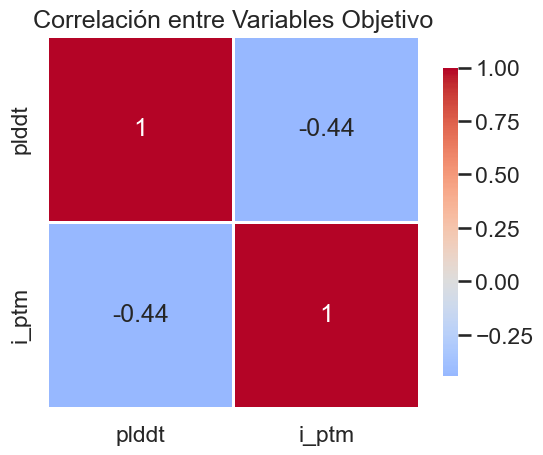

In [17]:
correlation = df[['plddt', 'i_ptm']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlación entre Variables Objetivo')
plt.show()

### 4. Procesamiento con Dataloader

In [18]:

from models.custom_dataloader import CustomProteinDataset
from torch.utils.data import DataLoader, random_split

#Creamos CustomDataset
CSV_PATH = "data/traning_alphafold_predictor/train.csv"
dataset =CustomProteinDataset(CSV_PATH)

#Train/Val Split
total_size = len(dataset)
train_size = int(total_size * 0.8)  # 80% para entrenamiento
val_size = total_size - train_size  # 20% para validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Dataloaders con Batch size
BATCH_SIZE = 16
data_loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Registros de entrenamiento: {len(train_dataset)}")
print(f"Registros de validación: {len(val_dataset)}")

Registros de entrenamiento: 1568
Registros de validación: 392


### 3. Tokenizador

In [19]:
next(iter(data_loader_train))

[('WIFRLYVSIGWGVPLLFVVPWGIVKYLYVNPVALLVGILLALLALLR',
  'VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLSCRLVFLLMQYCVAANYYWLLVEGVYLYTLLAFSVFSEQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKIKCRLAKSTLTLIPLLGTHEVIFAFVMDEHARGTLRFIKLFTELSFTSFQGLMVAISFGPEIDRGFLELYLLLAEK',
  'VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLSCRLVFLLMQYCVAANYYWLLVEGVYLYTLLAFSVFSEQWIFRLYVSIGWGVPLLFVVPWGIVKYLYEDEGCWTRNSNMNYWLIIRLPILFAIGVNFLIFVRVICIVVSKLKIKCRLAKSTLTLIPLLGTHEVIFAFVMDEHARGTLRFIKLFTELSFTSFQGLMVAIDATEELFRELAKLLELKALQ',
  'VSLWETVQKWREYRRQCQRSLTEDPPPATDLFCNRTFDEYACWPDGEPGSFVNVSCPWYLPWASSVPQGHVYRFCTAEGLWLQKDNSSLPWRDLSECEEEQLLFLYIIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFASFILRALSVFIKDAALKWMYSTAAQQHQWDGLLSYQDSLS

In [20]:

inputs = tokenizer(
    next(iter(data_loader_train))[0], 
    padding=True, #Padding para el mismo tamaño
    truncation=True, #Recorta en caso de que sean muy largas
    return_tensors="pt" #Regresa tensores de pytorch
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [21]:
inputs['input_ids'].shape

torch.Size([16, 375])

In [22]:
with torch.no_grad():
    # Pasamos los tensores tokenizados al modelo
    outputs = model(**inputs)

In [23]:
#Luego de pasar por la última capa tenemos  [num_secuencias, longitud_max_secuencia, dimension_emb]
outputs.last_hidden_state.shape 

torch.Size([16, 375, 1280])

In [24]:
embedding_por_residuo = outputs.last_hidden_state
embedding_por_secuencia = embedding_por_residuo.mean(dim=1) #Promedio por cada secuencia

In [25]:
embedding_por_secuencia.shape

torch.Size([16, 1280])

# Alternativas usando Deep Learniing

In [26]:
from models.mlp import MLP_pLDDT
import torch.nn as nn
import torch.optim as optim

input_size = 1280
hidden_sizes = [512]  # 1 capas ocultas
output_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model_mlp = MLP_pLDDT(input_size, hidden_sizes, output_size).to(device)
print(model_mlp)

criterion = nn.MSELoss()  # Mean Squared Error para regresión
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

MLP_pLDDT(
  (network): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [28]:
#MODELO DE MULTILAYER PERCEPTRON

# Early Stopping variables
EPOCHS = 100
paciencia = 10        # Épocas a esperar después de la última mejora
epochs_sin_mejora = 0 # Contador
best_val_loss = np.inf  # Inicia con infinito para que cualquier pérdida sea mejor
ruta_mejor_modelo = 'models/best_model_mlp.pth' # Dónde guardar el mejor modelo
# ----------------------------------------

mlp_train_losses = []
mlp_val_losses = []
for epoch in range(EPOCHS):
    #TRAINING
    model_mlp.train()
    total_epoch_loss = 0.0
    for i , (sequences_batch, plddts_batch,_) in enumerate(data_loader_train):
        plddts_batch = plddts_batch.to(device)
        inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings_batch = outputs.last_hidden_state.mean(dim=1)
        predictions = model_mlp(embeddings_batch)
        loss = criterion(predictions, plddts_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(data_loader_train)
    mlp_train_losses.append(avg_epoch_loss)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA")
    print(f"Pérdida Promedio de la Época: {avg_epoch_loss:.4f}")

    #VALIDATION
    model_mlp.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for i , (sequences_batch, plddts_batch,_) in enumerate(data_loader_val):
            plddts_batch = plddts_batch.to(device)
            inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            
            embeddings_batch = outputs.last_hidden_state.mean(dim=1)
            predictions = model_mlp(embeddings_batch)
            loss = criterion(predictions, plddts_batch)

            total_val_loss += loss.item()

    avg_epoch_loss_val = total_val_loss / len(data_loader_val)
    mlp_val_losses.append(avg_epoch_loss_val)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA VAL")
    print(f"Pérdida Promedio de la Época VAL: {avg_epoch_loss_val:.4f}")

    #Early Stopping Lógica
    if avg_epoch_loss_val < best_val_loss:
        # ¡Mejora!
        best_val_loss = avg_epoch_loss_val
        epochs_sin_mejora = 0
        
        # Guardamos los pesos del mejor modelo
        torch.save(model_mlp.state_dict(), ruta_mejor_modelo)
        print("¡Mejora detectada! Guardando modelo...")
    
    else:
        # No hubo mejora
        epochs_sin_mejora += 1
        print(f"Sin mejora. Contador: {epochs_sin_mejora}/{paciencia}")

    # Comprobamos si hemos superado la paciencia
    if epochs_sin_mejora >= paciencia:
        print(f"\n¡Parada temprana! No hubo mejora en {paciencia} épocas.")
        break  # Rompemos el bucle de entrenamiento




ÉPOCA 1 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0036
ÉPOCA 1 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0026
¡Mejora detectada! Guardando modelo...
ÉPOCA 2 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0028
ÉPOCA 2 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0025
¡Mejora detectada! Guardando modelo...
ÉPOCA 3 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0027
ÉPOCA 3 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0021
¡Mejora detectada! Guardando modelo...
ÉPOCA 4 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0024
ÉPOCA 4 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
¡Mejora detectada! Guardando modelo...
ÉPOCA 5 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0024
ÉPOCA 5 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
¡Mejora detectada! Guardando modelo...
ÉPOCA 6 / 100 FINALIZADA
Pérdida Promedio de la Época: 0.0023
ÉPOCA 6 / 100 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0020
Sin mejora. C

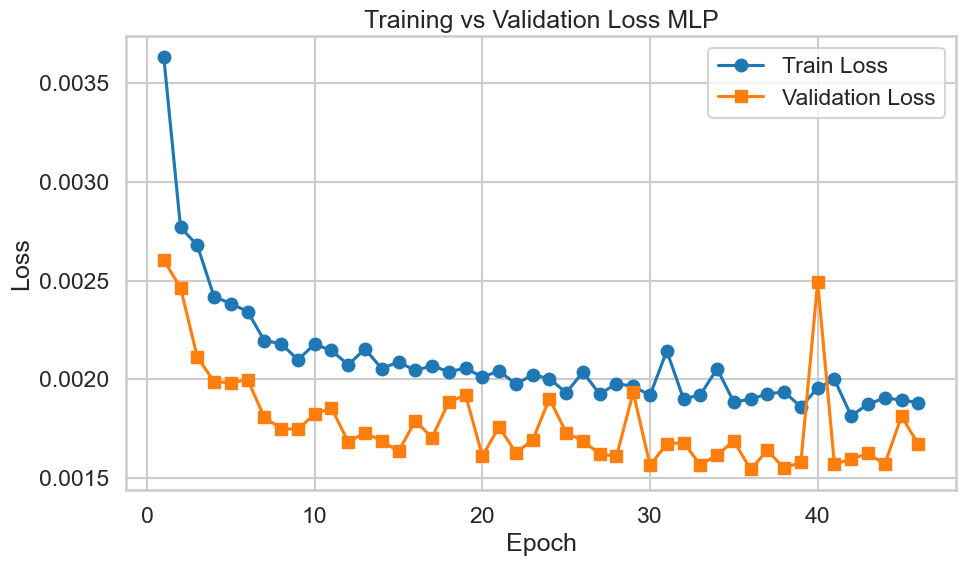

In [38]:
plt.figure(figsize=(10, 6))
epochs_used = range(1, len(mlp_train_losses)+ 1)
plt.plot(epochs_used, mlp_train_losses, label='Train Loss', marker='o')
plt.plot(epochs_used, mlp_val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(save_path, dpi=300)
plt.show()

In [ ]:
#Guardamos modelo 
#torch.save(model_mlp.state_dict(), 'mlp_weights.pth')

In [ ]:
#MODELO DE CONVOLUCIÓN 1 DIMENSIÓN
from models.conv1d_protein import Simple1CNN
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model_cnn = Simple1CNN().to(device)
print(model_cnn)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early Stopping variables
EPOCHS = 100
paciencia = 7
epochs_sin_mejora = 0
best_val_loss = np.inf
ruta_mejor_modelo = 'models/best_model_cnn.pth'

cnn_train_losses = []
cnn_val_losses = []

for epoch in range(EPOCHS):
    #TRAIN
    total_epoch_loss = 0.0
    model_cnn.train()
    for i , (sequences_batch, plddts_batch) in enumerate(data_loader_train):
        plddts_batch = plddts_batch.to(device)
        inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings_batch = outputs.last_hidden_state #Diferencia con el método anterior
        predictions = model_cnn(embeddings_batch)
        loss = criterion(predictions, plddts_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(data_loader_train)
    cnn_train_losses.append(avg_epoch_loss)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA")
    print(f"Pérdida Promedio de la Época: {avg_epoch_loss:.4f}")

    #VALIDATION
    model_cnn.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for i , (sequences_batch, plddts_batch) in enumerate(data_loader_val):
            plddts_batch = plddts_batch.to(device)
            inputs = tokenizer(sequences_batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            
            embeddings_batch = outputs.last_hidden_state #Difiere por naturaleza de Convolución, no hacemos promedio
            predictions = model_cnn(embeddings_batch)
            loss = criterion(predictions, plddts_batch)

            total_val_loss += loss.item()

    avg_epoch_loss_val = total_val_loss / len(data_loader_val)
    cnn_val_losses.append(avg_epoch_loss_val)
    print(f"ÉPOCA {epoch + 1} / {EPOCHS} FINALIZADA VAL")
    print(f"Pérdida Promedio de la Época VAL: {avg_epoch_loss_val:.4f}")

    #Early Stopping Lógica
    if avg_epoch_loss_val < best_val_loss:
        # ¡Mejora!
        best_val_loss = avg_epoch_loss_val
        epochs_sin_mejora = 0
        
        # Guardamos los pesos del mejor modelo
        torch.save(model_cnn.state_dict(), ruta_mejor_modelo)
        print("¡Mejora detectada! Guardando modelo...")
    
    else:
        # No hubo mejora
        epochs_sin_mejora += 1
        print(f"Sin mejora. Contador: {epochs_sin_mejora}/{paciencia}")

    # Comprobamos si hemos superado la paciencia
    if epochs_sin_mejora >= paciencia:
        print(f"\n¡Parada temprana! No hubo mejora en {paciencia} épocas.")
        break  # Rompemos el bucle de entrenamiento



Simple1CNN(
  (conv1): Conv1d(1280, 256, kernel_size=(5,), stride=(1,), padding=same)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
ÉPOCA 1 / 30 FINALIZADA
Pérdida Promedio de la Época: 0.0225
ÉPOCA 1 / 30 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0015
ÉPOCA 2 / 30 FINALIZADA
Pérdida Promedio de la Época: 0.0008
ÉPOCA 2 / 30 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0007
ÉPOCA 3 / 30 FINALIZADA
Pérdida Promedio de la Época: 0.0006
ÉPOCA 3 / 30 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0006
ÉPOCA 4 / 30 FINALIZADA
Pérdida Promedio de la Época: 0.0006
ÉPOCA 4 / 30 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0005
ÉPOCA 5 / 30 FINALIZADA
Pérdida Promedio de la Época: 0.0005
ÉPOCA 5 / 30 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0007
ÉPOCA 6 / 30 FINALIZADA
Pérdida Promedio de la Época: 0.0005
ÉPOCA 6 / 30 FINALIZADA VAL
Pérdida Promedio de la Época VAL: 0.0006
ÉPOCA 7 / 30 FINALIZADA
Pérdid

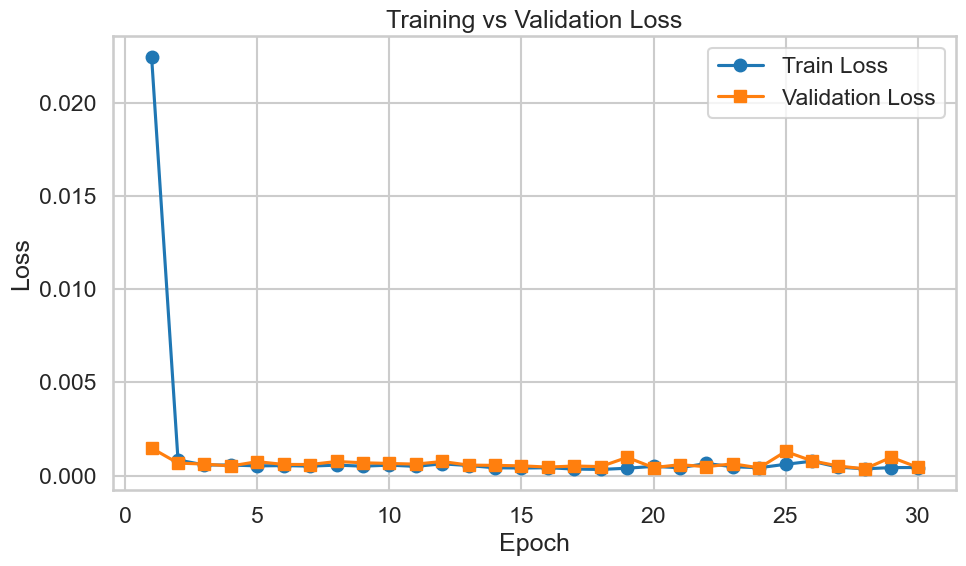

In [24]:
plt.figure(figsize=(10, 6))
epochs = range(1, EPOCHS+ 1)
plt.plot(epochs, cnn_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, cnn_val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(save_path, dpi=300)
plt.show()

# Modelo de XGboost y RandomForest de ML clásico

In [69]:
#TRAIN DATA LOADER to numpy array
train_data = []
train_targets = []

for data, target in train_dataset:
    target = target.to(device)
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    train_targets.append(target.cpu().numpy()[0])
    train_data.append(outputs.pooler_output.cpu().numpy()[0])

train_data_np = np.array(train_data)
train_targets_np = np.array(train_targets)


#VAL DATA LOADER to numpy array
val_data = []
val_targets = []

for data, target in val_dataset:
    target = target.to(device)
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    val_targets.append(target.cpu().numpy()[0])
    val_data.append(outputs.pooler_output.cpu().numpy()[0])
    
val_data_np = np.array(val_data)
val_targets_np = np.array(val_targets)

In [70]:
train_data_np.shape, train_targets_np.shape , val_data_np.shape, val_targets_np.shape

((588, 1280), (588,), (252, 1280), (252,))

In [73]:
#Entrenamos un RandomForestRegressor para ver como desempeñaría

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(train_data_np, train_targets_np)

print("Evaluando en el conjunto de train")
y_pred_train = random_forest.predict(train_data_np)

mse = mean_squared_error(train_targets_np, y_pred_train)
print(f"\nError Cuadrático Medio (MSE) en train: {mse:.6f}")

print("Evaluando en el conjunto de val")
y_pred_val = random_forest.predict(val_data_np)

mse = mean_squared_error(val_targets_np, y_pred_val)
print(f"\nError Cuadrático Medio (MSE) en val: {mse:.6f}")

Evaluando en el conjunto de train

Error Cuadrático Medio (MSE) en train: 0.000044
Evaluando en el conjunto de val

Error Cuadrático Medio (MSE) en val: 0.000325


Entrenando modelo Gradient Boosting...
¡Cálculo de pérdidas completado!


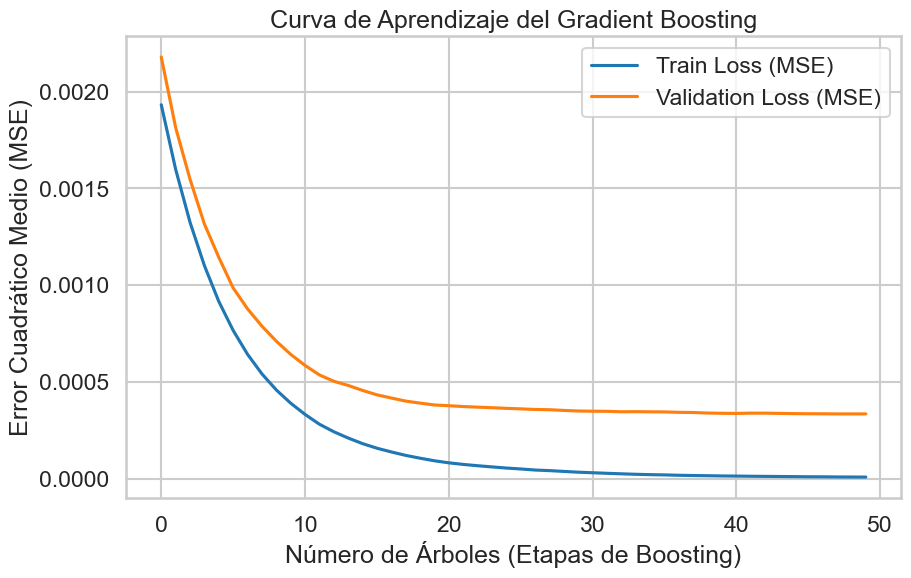

In [75]:
%matplotlib inline
#Entrenamos un GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

model_gbm = GradientBoostingRegressor(n_estimators=50, random_state=42,max_depth=5)

print("Entrenando modelo Gradient Boosting...")
model_gbm.fit(train_data_np, train_targets_np)

# Calcula el MSE en el conjunto de entrenamiento en cada etapa
train_preds_staged = model_gbm.staged_predict(train_data_np)
train_losses = [mean_squared_error(train_targets_np, preds) for preds in train_preds_staged]

# Calcula el MSE en el conjunto de validación en cada etapa
test_preds_staged = model_gbm.staged_predict(val_data_np)
test_losses = [mean_squared_error(val_targets_np, preds) for preds in test_preds_staged]

print("¡Cálculo de pérdidas completado!")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss (MSE)")
plt.plot(test_losses, label="Validation Loss (MSE)")
plt.xlabel("Número de Árboles (Etapas de Boosting)")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("Curva de Aprendizaje del Gradient Boosting")
plt.legend()
plt.grid(True)
plt.show()

Entrenando modelo XGBoost...
¡Entrenamiento completado!
------------------------------
Métricas Finales (última etapa):
Error Cuadrático Medio Raíz(RMSE) en train: 0.0003
Error Cuadrático Medio Raiz(RMSE) en val:   0.0200
------------------------------


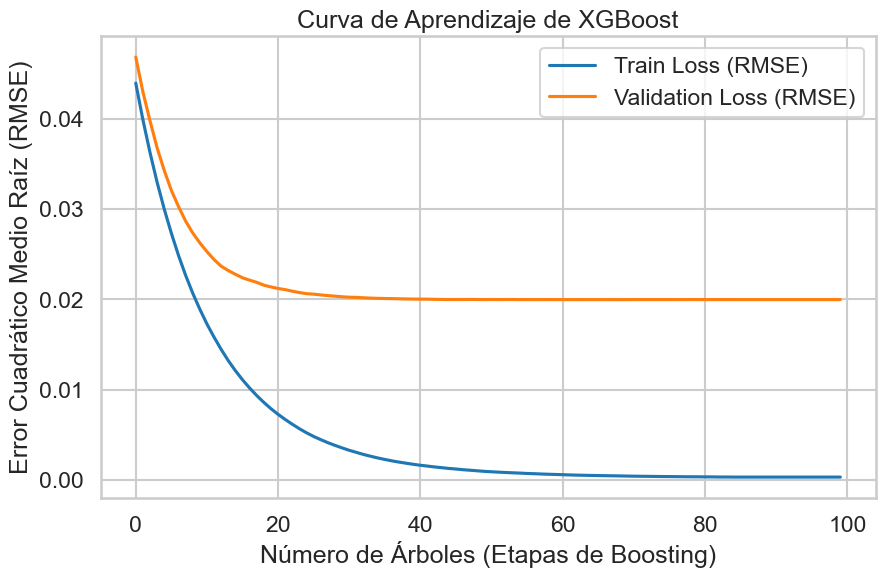

In [79]:
#Modelo de XGBOOST 
import xgboost as xgb

eval_set = [
    (train_data_np, train_targets_np),  # Etiquetado como 'validation_0'
    (val_data_np, val_targets_np)     # Etiquetado como 'validation_1'
]

model_xgb = xgb.XGBRegressor(n_estimators=100,random_state=42,max_depth=8,learning_rate=0.1,eval_metric="rmse")


print("Entrenando modelo XGBoost...")

model_xgb.fit(
    train_data_np, train_targets_np,
    eval_set=eval_set,   # Los datos para monitorear
    verbose=False        # Para no imprimir el log de cada etapa
)

print("¡Entrenamiento completado!")

results = model_xgb.evals_result()

train_losses = results['validation_0']['rmse']
test_losses = results['validation_1']['rmse']

#Imprime las métricas finales
print("-" * 30)
print("Métricas Finales (última etapa):")
print(f"Error Cuadrático Medio Raíz(RMSE) en train: {train_losses[-1]:.4f}")
print(f"Error Cuadrático Medio Raiz(RMSE) en val:   {test_losses[-1]:.4f}")
print("-" * 30)

#Graficamos
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss (RMSE)")
plt.plot(test_losses, label="Validation Loss (RMSE)")
plt.xlabel("Número de Árboles (Etapas de Boosting)")
plt.ylabel("Error Cuadrático Medio Raíz (RMSE)")
plt.title("Curva de Aprendizaje de XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [80]:
#Modelo Regularizado Lineal
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data_np)
X_test_scaled = scaler.transform(val_data_np)

model_ridge = Ridge(alpha=1.0) 
model_ridge.fit(X_train_scaled, train_targets_np)

y_pred = model_ridge.predict(X_train_scaled)
mse = mean_squared_error(train_targets_np, y_pred)
print(f"MSE del Modelo Ridge Train: {mse:.5f}")

y_pred = model_ridge.predict(X_test_scaled)
mse = mean_squared_error(val_targets_np, y_pred)
print(f"MSE del Modelo Ridge Val: {mse:.5f}")

MSE del Modelo Ridge Train: 0.00004
MSE del Modelo Ridge Val: 0.00044


# Predictor para ipTM de Alphafold